# HW3: Dueling Double DQN

This homework demands you to implement a DQN with some advanced tricks from RAINBOW:
* N-step target without off-policy correction
* Dueling Networks

Papers:
* DQN: https://arxiv.org/abs/1312.5602

* RAINBOW: https://arxiv.org/abs/1710.02298

* APE-X paper: https://arxiv.org/abs/1803.00933



You will run your agent on Atari Breakout environment: https://ale.farama.org/environments/breakout/

Atari docs: https://ale.farama.org/environments/

A paper about Atari benchmark in general: https://arxiv.org/abs/1709.06009

In [1]:
import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
#     !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/atari_wrappers.py
#     !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/utils.py
#     !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/framebuffer.py

#     !pip -q install gymnasium[atari]==1.0.0

#     !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [2]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [3]:
import gymnasium as gym
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import ale_py

gym.register_envs(ale_py)
%matplotlib inline

Let's play some old videogames. This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.

In [4]:
ENV_NAME = "ALE/Breakout-v5"

# Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


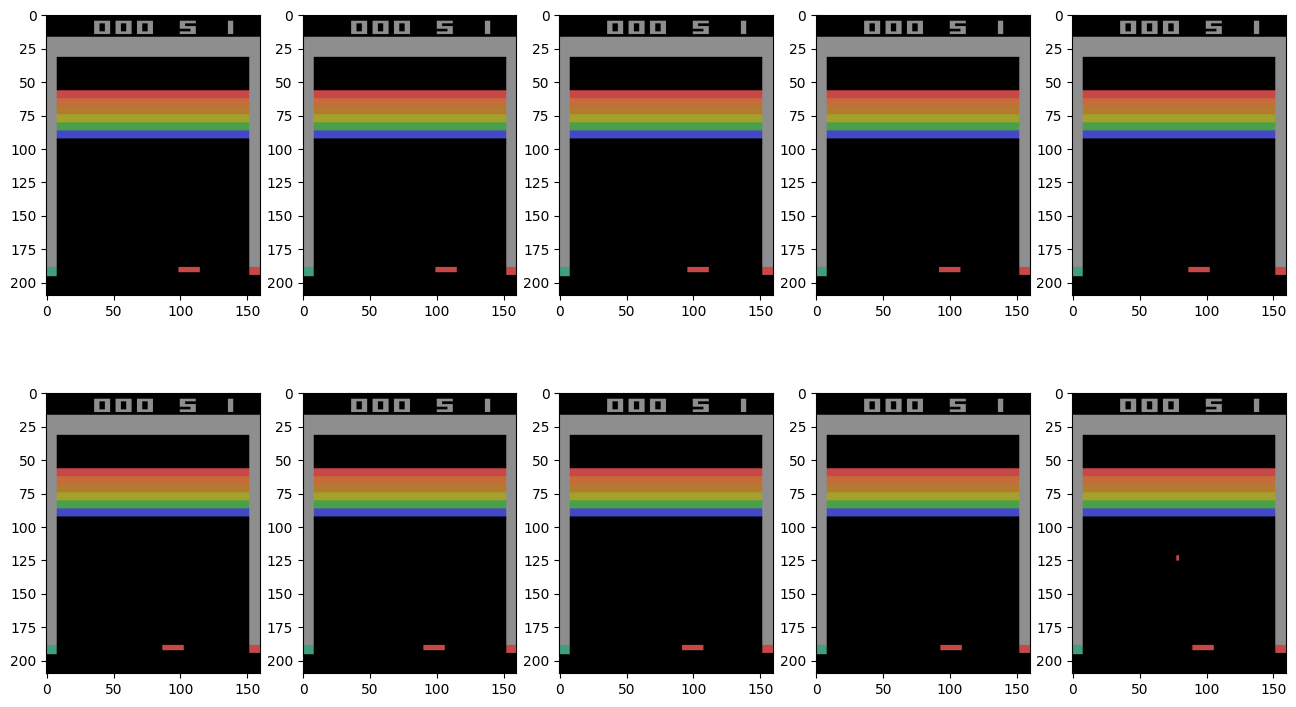

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array",
               frameskip=1, repeat_action_probability=0.0)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

### Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This trick is not necessary but it will speed up learning.

In [6]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        super().__init__(env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[...,:3], channel_weights)[None, :, :]

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[31:-17, 7:-8] # crop
        img = cv2.resize(img, (64, 64)) # resize
        img = self._to_gray_scale(img) # grayscale
        img = img.astype(np.float32) / 256 # float
        return img

Formal tests seem fine. Here's an example of what you'll get.


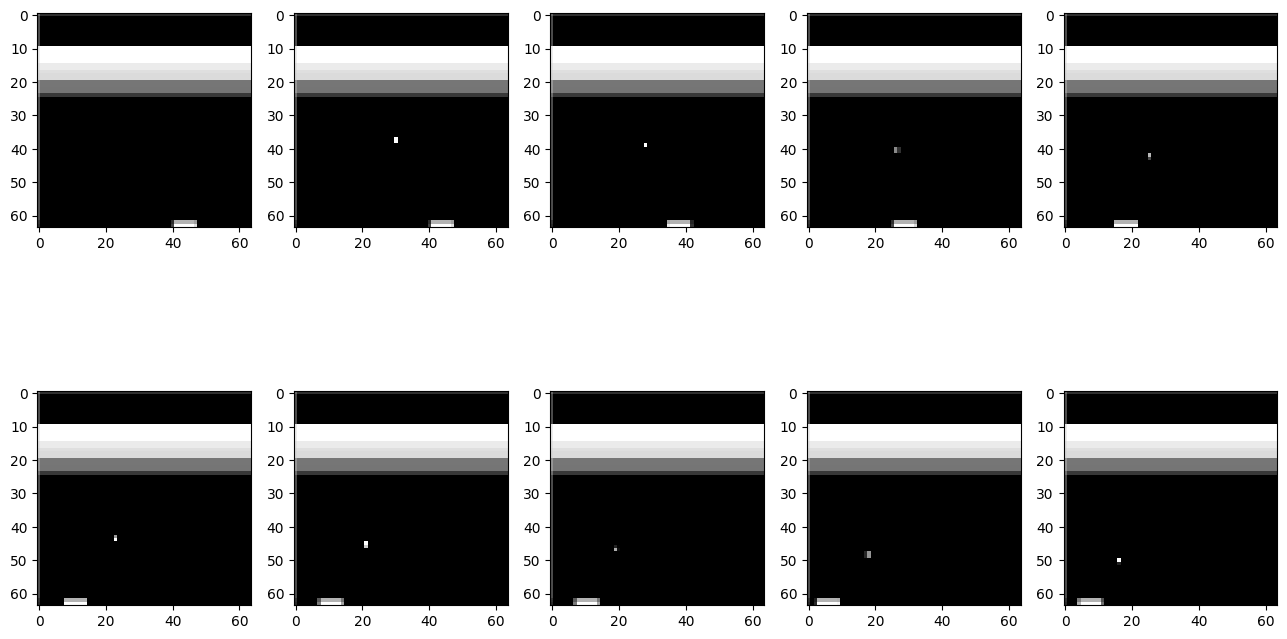

In [7]:
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1. / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [8]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [9]:
from framebuffer import FrameBuffer
import utils

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(np.int64(4), (4, 64, 64))

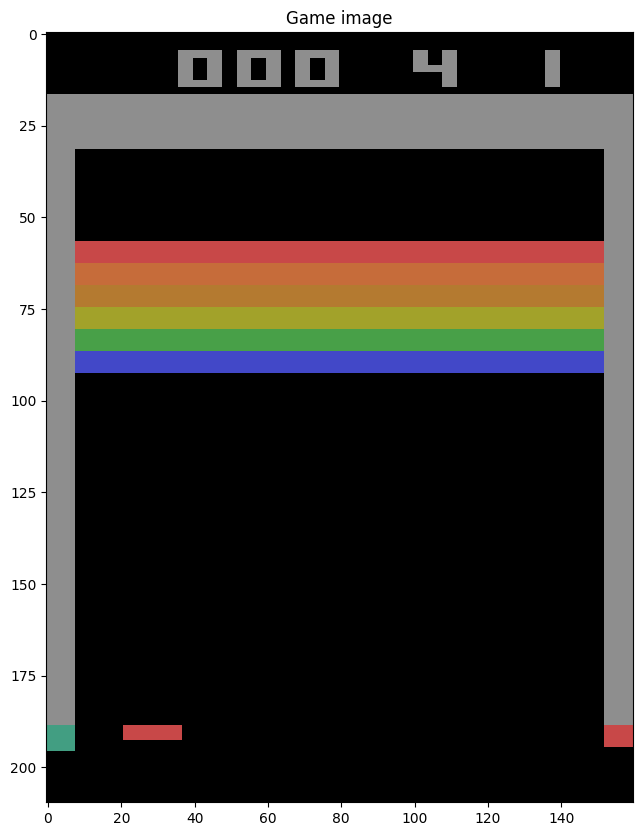

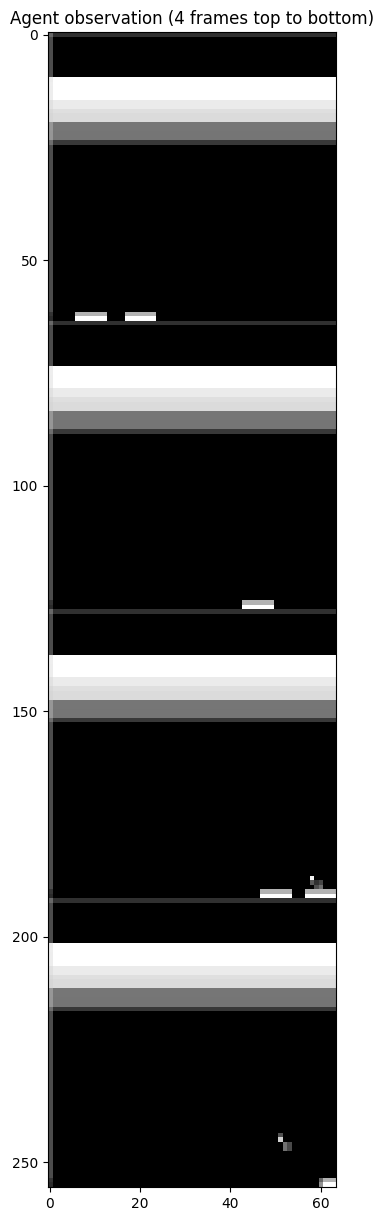

In [10]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15, 15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

# Dueling DDQN as it is


* Dueling network
* Replay buffer
* Double DQN with target network

### Dueling network (1 point)
Paper: https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\xi}(s) + A_{\psi}(s, a) - \frac{\sum_{a'}A_{\psi}(s, a')}{N_{actions}},$$

This is what it looks like:

Expects height=width=64

<!-- <img src="img/dueling_basic.png" alt="dueling_basic" width="500"/> -->
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/week04_approx_rl/img/dueling_basic.png)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [12]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [13]:
class DuelingNetwork(nn.Module):
    """
    Implement the Dueling DQN logic.
    """
    def __init__(self, n_actions, inp_size, hidden_size) -> None:
        super().__init__()
        self.n_actions = n_actions
        self.inp_size = inp_size
        self.hidden_size = hidden_size
        
        self.features = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, n_actions)
        )
        
        self.value = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2, x.shape  # (batch_size, n_features)
        
        features = self.features(x)
        
        advantage = self.advantage(features)
        value = self.value(features)
        
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        return value + advantage - advantage.mean(dim=1, keepdim=True)

Since both the advantage and the value stream propagate gradients to the last convolutional layer in the backward pass, we rescale the combined gradient entering the last convolutional layer by $\frac{1}{\sqrt{2}}$. This simple heuristic mildly increases stability.

In [14]:
class GradScalerFunctional(torch.autograd.Function):
    """
    A torch.autograd.Function works as Identity on forward pass
    and scales the gradient by scale_factor on backward pass.
    """
    @staticmethod
    def forward(ctx, input, scale_factor):
        ctx.scale_factor = scale_factor
        return input

    @staticmethod
    def backward(ctx, grad_output):
        scale_factor = ctx.scale_factor
        grad_input = grad_output * scale_factor
        return grad_input, None


class GradScaler(nn.Module):
    """
    An nn.Module incapsulating GradScalerFunctional
    """
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return GradScalerFunctional.apply(x, self.scale_factor)

In [15]:
from typing import Tuple, List, Optional, Union
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor


class DQNAgent(nn.Module):
    """
    Deep Q-Network agent with dueling architecture for reinforcement learning.
    
    This agent processes state observations through a convolutional neural network
    and uses a dueling network architecture to separate state value and advantage
    estimations for improved learning.
    """
    
    def __init__(
        self, 
        state_shape: Tuple[int, int, int], 
        n_actions: int, 
        epsilon: float = 0
    ) -> None:
        """
        Initialize the DQN agent.
        
        Parameters
        ----------
        state_shape : Tuple[int, int, int]
            Shape of the state observation (channels, height, width)
        n_actions : int
            Number of possible actions
        epsilon : float, optional
            Exploration rate for epsilon-greedy policy, by default 0
        """
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        n_input_channels = state_shape[0]
        h, w = state_shape[1], state_shape[2]
        
        self.conv = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calculate convolutional output dimensions
        conv_out_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        conv_out_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        conv_out_size = conv_out_h * conv_out_w * 64
        
        self.dueling_network = DuelingNetwork(
            n_actions=n_actions,
            inp_size=conv_out_size,
            hidden_size=512
        )
        
        self.scale = GradScaler(1.0 / 255)

    def forward(self, state_t: Tensor) -> Tensor:
        """
        Process state observations through the network to get Q-values.
        
        Parameters
        ----------
        state_t : Tensor
            Batch of state observations, shape [batch_size, channels, height, width]
            
        Returns
        -------
        Tensor
            Q-values for each action, shape [batch_size, n_actions]
        """
        x = self.scale(state_t)
        batch_size = x.shape[0]
        conv_features = self.conv(x)
        flat_features = conv_features.view(batch_size, -1)
        return self.dueling_network(flat_features)

    @torch.inference_mode()
    def get_qvalues(self, states: Union[List, np.ndarray]) -> np.ndarray:
        """
        Get Q-values for given states, works with numpy arrays or lists.
        
        Parameters
        ----------
        states : Union[List, np.ndarray]
            Batch of state observations
            
        Returns
        -------
        np.ndarray
            Q-values for each action
        """
        # Ensure input is a numpy array for efficiency
        if not isinstance(states, np.ndarray):
            states = np.array(states, dtype=np.float32)
            
        # Convert to tensor and process
        states_t = torch.from_numpy(states).to(device, dtype=torch.float32)
        qvalues_t = self(states_t)
        return qvalues_t.cpu().numpy()

    def sample_actions_by_qvalues(self, qvalues: np.ndarray, greedy: bool = False) -> np.ndarray:
        """
        Sample actions based on Q-values using epsilon-greedy strategy.
        
        Parameters
        ----------
        qvalues : np.ndarray
            Q-values for each action, shape [batch_size, n_actions]
        greedy : bool, optional
            Whether to use greedy action selection, by default False
            
        Returns
        -------
        np.ndarray
            Selected actions, shape [batch_size]
        """
        batch_size, n_actions = qvalues.shape
        
        if greedy:
            actions = qvalues.argmax(axis=-1)
        else:
            should_explore = np.random.random(batch_size) < self.epsilon
            greedy_actions = qvalues.argmax(axis=-1)
            random_actions = np.random.randint(0, n_actions, size=batch_size)
            actions = np.where(should_explore, random_actions, greedy_actions)
            
        return actions

    def sample_actions(self, states: Union[List, np.ndarray], greedy: bool = False) -> np.ndarray:
        """
        Get actions for given states according to epsilon-greedy policy.
        
        Parameters
        ----------
        states : Union[List, np.ndarray]
            Batch of state observations
        greedy : bool, optional
            Whether to use greedy action selection, by default False
            
        Returns
        -------
        np.ndarray
            Selected actions, shape [batch_size]
        """
        qvalues = self.get_qvalues(states)
        return self.sample_actions_by_qvalues(qvalues, greedy)

In [16]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [17]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            action = agent.sample_actions([s], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [18]:
evaluate(env, agent, n_games=1)

np.float64(0.0)

# Experience Replay
There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: Experience Replay. The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer.
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [19]:
from typing import Tuple
from collections import deque

In [20]:
import numpy as np
from typing import Tuple
import torch

class ReplayBuffer:
    def __init__(self, size: int, state_shape: Tuple[int], device: torch.device) -> None:
        self._maxsize = size
        self._device = device
        self._next_idx = 0
        self._size = 0

        self._obs_t = np.zeros((size, *state_shape), dtype=np.float32)
        self._actions = np.zeros(size, dtype=np.int64)
        self._rewards = np.zeros(size, dtype=np.float32)
        self._obs_tp1 = np.zeros((size, *state_shape), dtype=np.float32)
        self._done = np.zeros(size, dtype=np.bool_)

    def __len__(self) -> int:
        return self._size

    def add(self, obs_t: np.ndarray, action: int, reward: float, obs_tp1: np.ndarray, done: bool) -> None:
        self._obs_t[self._next_idx] = obs_t
        self._actions[self._next_idx] = action
        self._rewards[self._next_idx] = reward
        self._obs_tp1[self._next_idx] = obs_tp1
        self._done[self._next_idx] = done

        self._next_idx = (self._next_idx + 1) % self._maxsize
        self._size = min(self._size + 1, self._maxsize)

    def sample(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        indices = np.random.randint(0, self._size, size=batch_size)

        obs_batch = torch.tensor(self._obs_t[indices], device=self._device)
        act_batch = torch.tensor(self._actions[indices], device=self._device)
        rew_batch = torch.tensor(self._rewards[indices], device=self._device)
        next_obs_batch = torch.tensor(self._obs_tp1[indices], device=self._device)
        done_batch = torch.tensor(self._done[indices], device=self._device, dtype=torch.float32)
        
        return obs_batch, act_batch, rew_batch, next_obs_batch, done_batch

In [21]:
state_shape = env.observation_space.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

exp_replay = ReplayBuffer(size=10, state_shape=state_shape, device=device)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [22]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has terminated=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        action = agent.sample_actions([s])[0]
        next_s, r, terminated, truncated, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, terminated)
        sum_rewards += r
        s = next_s
        if terminated or truncated:
            s, _ = env.reset()

    return sum_rewards, s

In [23]:
# Убедитесь, что exp_replay инициализирован с достаточным размером
exp_replay = ReplayBuffer(size=2000, state_shape=state_shape, device=device)

# Добавьте больше шагов с помощью play_and_record
state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# Проверка длины буфера
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, " \
                                "but instead added %i" % len(exp_replay)

# Проверка значений is_done
is_dones = exp_replay._done[:len(exp_replay)]

# Теперь можно проводить дальнейшие проверки
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert np.all(np.isin(is_done_batch.cpu().numpy(), [0, 1])), "is_done should be strictly True or False"
    assert np.all((0 <= act_batch.cpu().numpy()) & (act_batch.cpu().numpy() < n_actions)), "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=640>

In [24]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Double DQN (1 point)

To prevent overestimation bias we also decouple action selection from action evaluation using agent's network and target network respectively.

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{
  \theta}(s', a')) $$

# Learning with... double Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_{(s, a)} [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

#### 1-step Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{\theta}(s', a')) $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.



__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).


In [25]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_agent,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    states = states.to(device, dtype=torch.float)  # shape: [batch_size, *state_shape]
    actions = actions.to(device, dtype=torch.long)  # shape: [batch_size]
    rewards = rewards.to(device, dtype=torch.float)  # shape: [batch_size]
    next_states = next_states.to(device, dtype=torch.float)  # shape: [batch_size, *state_shape]
    is_done = is_done.to(device, dtype=torch.float)  # shape: [batch_size]
    is_not_done = 1 - is_done

    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    with torch.no_grad():
        predicted_next_qvalues = agent(next_states)
        target_predicted_next_qvalues = target_agent(next_states)

    predicted_qvalues_for_actions = predicted_qvalues.gather(1, actions.unsqueeze(-1)).squeeze(-1)

    best_actions = predicted_next_qvalues.argmax(dim=1)
    next_state_values = target_predicted_next_qvalues.gather(1, best_actions.unsqueeze(-1)).squeeze(-1)

    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert not target_qvalues_for_actions.requires_grad, "do not send gradients to target!"

    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [26]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [27]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

# Main loop (3 points)

It's time to put everything together and see if it learns anything.

In [28]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [29]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [30]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [42]:
exp_replay = ReplayBuffer(size=10**5, state_shape=state_shape, device=device)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**5)
    if len(exp_replay) == 10**5:
        break
print(len(exp_replay))

100000


In [49]:
timesteps_per_epoch = 1
batch_size = 32000
total_steps = 9 * 10**3
decay_steps = 3 * 10**3

import bitsandbytes as bnb
opt = bnb.optim.Adam8bit(agent.parameters(), lr=1e-4, eps=1e-3)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 10
refresh_target_network_freq = 150
eval_freq = 150

max_grad_norm = 50

n_lives = 5

In [50]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 1.00000


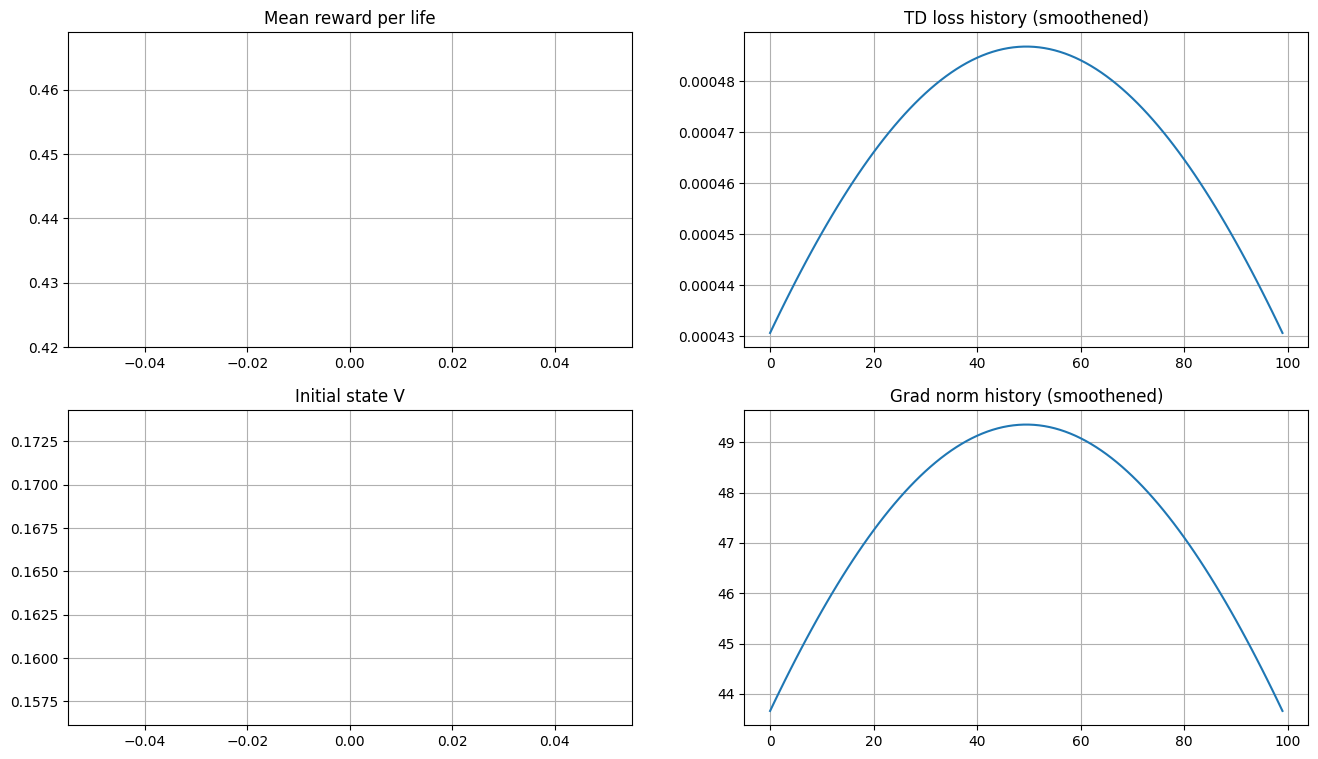

  0%|                                                                             | 5/9001 [00:09<4:27:47,  1.79s/it]

In [ ]:
scaler = torch.amp.GradScaler('cuda')

state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                              agent, target_network,
                              gamma=0.99)

    opt.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    scaler.step(opt)
    scaler.update()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * 3, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()
        plt.show()

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 20 points in the real env**. So 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 20, 'not as cool as DQN can'
print('Cool!')

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

# Record a video

In [ ]:
# record sessions
from gymnasium.wrappers import RecordVideo

with RecordVideo(env=make_env(), video_folder='./videos',
                 episode_trigger = lambda episode_number: True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives,
                         greedy=True) for _ in range(10)]
env.close()

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Let's have a closer look at this (up to 1 point)

Make a more complete record of an episode.

In [ ]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$
$$\hat V_{agent}(s) = \max_a \hat Q(s,a).$$

Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

In [ ]:
from utils import play_and_log_episode, img_by_obs
import matplotlib.pyplot as plt
import numpy as np

def compute_q_spread(agent, states):
    q_values = agent.get_qvalues(states)
    return np.max(q_values, axis=1) - np.min(q_values, axis=1)

def plot_states(states, titles, nrows=1, ncols=3, figsize=(15, 5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, (state, title) in enumerate(zip(states, titles)):
        ax = axes[i] if nrows == 1 else axes[i // ncols, i % ncols]
        ax.imshow(img_by_obs(state))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

eval_env = make_env(clip_rewards=False)

high_spread_states, low_spread_states = [], []
high_spread_titles, low_spread_titles = [], []

for _ in range(5):
    record = play_and_log_episode(eval_env, agent)
    states = np.array(record['observations'])
    q_spreads = compute_q_spread(agent, states)

    high_spread_idx = np.argsort(q_spreads)[-3:]
    high_spread_states.extend(states[high_spread_idx])
    high_spread_titles.extend([f"High Q-Spread: {q_spreads[idx]:.2f}" for idx in high_spread_idx])

    low_spread_idx = np.argsort(q_spreads)[:3]
    low_spread_states.extend(states[low_spread_idx])
    low_spread_titles.extend([f"Low Q-Spread: {q_spreads[idx]:.2f}" for idx in low_spread_idx])

plot_states(high_spread_states, high_spread_titles, nrows=1, ncols=3, figsize=(15, 5))

plot_states(low_spread_states, low_spread_titles, nrows=1, ncols=3, figsize=(15, 5))

high_td_error_states, high_v_diff_states = [], []
high_td_error_titles, high_v_diff_titles = [], []

for _ in range(5):
    record = play_and_log_episode(eval_env, agent)
    states = np.array(record['observations'])
    rewards = np.array(record['rewards'])
    v_mc = np.array(record['v_mc'])
    v_agent = np.array(record['v_agent'])

    td_errors = np.abs(rewards[:-1] + gamma * v_agent[1:] - v_agent[:-1])

    v_diffs = np.abs(v_mc - v_agent)

    high_td_error_idx = np.argsort(td_errors)[-3:]
    high_td_error_states.extend(states[high_td_error_idx])
    high_td_error_titles.extend([f"High TD-Error: {td_errors[idx]:.2f}" for idx in high_td_error_idx])

    high_v_diff_idx = np.argsort(v_diffs)[-3:]
    high_v_diff_states.extend(states[high_v_diff_idx])
    high_v_diff_titles.extend([f"High |V_MC - V_agent|: {v_diffs[idx]:.2f}" for idx in high_v_diff_idx])

plot_states(high_td_error_states, high_td_error_titles, nrows=1, ncols=3, figsize=(15, 5))

plot_states(high_v_diff_states, high_v_diff_titles, nrows=1, ncols=3, figsize=(15, 5))

# Bonus area
# Apply modifications to DQN

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

* [Quantile Regression DQN](https://arxiv.org/abs/1710.10044) (1.5 pt)
* [Prioritized Experience Replay](https://arxiv.org/abs/1710.10044) (2 pt)
* [n-step target without off-policy correction](https://arxiv.org/abs/1901.07510) (1 pt)
* [Clipped Double DQN](https://arxiv.org/abs/1802.09477v3) (0.5 pt)
* [Noisy networks](https://arxiv.org/abs/1706.10295) (1 pts)
* [DRQN](https://arxiv.org/abs/1507.06527) (3 pt)

## Noisy networks

In [ ]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, sigma_init: float = 0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.sigma_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.sigma_init / np.sqrt(self.out_features))

    def reset_noise(self):
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

## DRQN

In [ ]:
class DRQN(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size=512):
        super(DRQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(input_size=self._conv_output_size(state_shape), hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_actions)

    def _conv_output_size(self, state_shape):
        h, w = state_shape[1], state_shape[2]
        conv_out_h = (h - 8) // 4 + 1
        conv_out_h = (conv_out_h - 4) // 2 + 1
        conv_out_h = (conv_out_h - 3) // 1 + 1

        conv_out_w = (w - 8) // 4 + 1
        conv_out_w = (conv_out_w - 4) // 2 + 1
        conv_out_w = (conv_out_w - 3) // 1 + 1

        return conv_out_h * conv_out_w * 64

    def forward(self, x, hidden_state=None):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.conv(x).view(batch_size, seq_len, -1)
        x, hidden_state = self.lstm(x, hidden_state)
        return self.fc(x[:, -1]), hidden_state

## Clipped Double DQN

In [ ]:
def compute_clipped_double_q_loss(states, actions, rewards, next_states, is_done, agent, target_agent, gamma=0.99):
    q1 = agent(states)
    q2 = target_agent(states)

    q1_selected = q1.gather(1, actions.unsqueeze(-1)).squeeze(-1)
    q2_selected = q2.gather(1, actions.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_q_values = torch.min(agent(next_states), target_agent(next_states)).max(1)[0]
        target_q_values = rewards + gamma * next_q_values * (1 - is_done)

    loss = F.mse_loss(q1_selected, target_q_values) + F.mse_loss(q2_selected, target_q_values)
    return loss

## n-step target without off-policy correction

In [ ]:
class NStepReplayBuffer:
    def __init__(self, n_step, gamma):
        self.n_step = n_step
        self.gamma = gamma
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)
        if len(self.buffer) > self.n_step:
            self.buffer.pop(0)

    def get_n_step_transition(self):
        if len(self.buffer) < self.n_step:
            return None

        obs_t, action, reward, obs_tp1, done = self.buffer[0]
        for i in range(1, self.n_step):
            _, _, rew, next_obs, is_done = self.buffer[i]
            reward += (self.gamma ** i) * rew
            obs_tp1, done = next_obs, is_done
            if done:
                break

        return obs_t, action, reward, obs_tp1, done

## Prioritized Experience Replay

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha):
        self._maxsize = size
        self._alpha = alpha
        self._storage = []
        self._priorities = np.zeros((size,), dtype=np.float32)
        self._next_idx = 0

    def add(self, obs_t, action, reward, obs_tp1, done):
        max_priority = self._priorities.max() if self._storage else 1.0
        if len(self._storage) < self._maxsize:
            self._storage.append((obs_t, action, reward, obs_tp1, done))
        else:
            self._storage[self._next_idx] = (obs_t, action, reward, obs_tp1, done)
        self._priorities[self._next_idx] = max_priority
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size, beta):
        if len(self._storage) == 0:
            raise ValueError("The replay buffer is empty.")

        priorities = self._priorities[:len(self._storage)]
        probabilities = priorities ** self._alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self._storage), batch_size, p=probabilities)
        weights = (len(self._storage) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = [], [], [], [], []
        for idx in indices:
            data = self._storage[idx]
            obs_batch.append(data[0])
            act_batch.append(data[1])
            rew_batch.append(data[2])
            next_obs_batch.append(data[3])
            done_batch.append(data[4])

        return (
            np.array(obs_batch),
            np.array(act_batch),
            np.array(rew_batch),
            np.array(next_obs_batch),
            np.array(done_batch),
            indices,
            np.array(weights, dtype=np.float32),
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self._priorities[idx] = priority

## Quantile Regression DQN

In [ ]:
class QuantileRegressionDQN(nn.Module):
    def __init__(self, state_shape, n_actions, num_atoms=51, v_min=-10, v_max=10):
        super(QuantileRegressionDQN, self).__init__()
        self.n_actions = n_actions
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms)

        self.conv = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._conv_output_size(state_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions * num_atoms),
        )

    def _conv_output_size(self, state_shape):
        h, w = state_shape[1], state_shape[2]
        conv_out_h = (h - 8) // 4 + 1
        conv_out_h = (conv_out_h - 4) // 2 + 1
        conv_out_h = (conv_out_h - 3) // 1 + 1

        conv_out_w = (w - 8) // 4 + 1
        conv_out_w = (conv_out_w - 4) // 2 + 1
        conv_out_w = (conv_out_w - 3) // 1 + 1

        return conv_out_h * conv_out_w * 64

    def forward(self, x):
        batch_size = x.shape[0]
        conv_out = self.conv(x).view(batch_size, -1)
        q_atoms = self.fc(conv_out).view(batch_size, self.n_actions, self.num_atoms)
        q_atoms = F.softmax(q_atoms, dim=2)  # Probability distribution
        return q_atoms

    def get_qvalues(self, x):
        q_atoms = self.forward(x)
        q_values = torch.sum(q_atoms * self.support, dim=2)
        return q_values

In [ ]:
class RainbowAgent:
    def __init__(self, state_shape: Tuple[int, int, int], n_actions: int, device: torch.device):
        self.n_actions = n_actions
        self.device = device
        self.network = QuantileRegressionDQN(state_shape, n_actions).to(device)
        self.target_network = QuantileRegressionDQN(state_shape, n_actions).to(device)
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()

    def sample_action(self, state, epsilon: float):
        if random.random() < epsilon:
            return random.randint(0, self.n_actions - 1)
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        q_values = self.network.get_qvalues(state_tensor)
        return torch.argmax(q_values).item()

def train_rainbow(
    env,
    state_shape: Tuple[int, int, int],
    n_actions: int,
    total_steps: int = 3_000_000,
    batch_size: int = 32,
    gamma: float = 0.99,
    n_step: int = 3,
    alpha: float = 0.6,
    beta_start: float = 0.4,
    beta_end: float = 1.0,
    lr: float = 1e-4,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.01,
    epsilon_decay_steps: int = 1_000_000,
    target_update_freq: int = 5000,
    eval_freq: int = 10_000,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    agent = RainbowAgent(state_shape, n_actions, device)
    replay_buffer = PrioritizedReplayBuffer(size=1_000_000, alpha=alpha)
    n_step_buffer = NStepReplayBuffer(n_step=n_step, gamma=gamma)
    optimizer = optim.Adam(agent.network.parameters(), lr=lr)

    state, _ = env.reset()
    epsilon = epsilon_start
    beta = beta_start
    mean_rewards = []
    td_errors = []

    for step in trange(total_steps):
        epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * step / epsilon_decay_steps)
        beta = min(beta_end, beta_start + (beta_end - beta_start) * step / total_steps)

        action = agent.sample_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        n_step_buffer.add((state, action, reward, next_state, terminated))

        if terminated or truncated:
            state, _ = env.reset()
        else:
            state = next_state

        n_step_transition = n_step_buffer.get_n_step_transition()
        if n_step_transition:
            replay_buffer.add(*n_step_transition)

        if step > batch_size and step % 4 == 0:
            batch = replay_buffer.sample(batch_size, beta)
            loss = compute_loss(batch, agent, gamma, n_step)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.network.parameters(), 10)
            optimizer.step()
            td_errors.append(loss.item())

        if step % target_update_freq == 0:
            agent.target_network.load_state_dict(agent.network.state_dict())

        if step % eval_freq == 0:
            rewards = evaluate_policy(env, agent, n_games=5)
            mean_rewards.append(np.mean(rewards))
            plot_metrics(mean_rewards, td_errors)

def compute_loss(batch, agent, gamma, n_step):
    obs, actions, rewards, next_obs, dones, indices, weights = batch
    obs = torch.tensor(obs, device=agent.device, dtype=torch.float32)
    actions = torch.tensor(actions, device=agent.device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=agent.device, dtype=torch.float32)
    next_obs = torch.tensor(next_obs, device=agent.device, dtype=torch.float32)
    dones = torch.tensor(dones, device=agent.device, dtype=torch.float32)
    weights = torch.tensor(weights, device=agent.device, dtype=torch.float32)

    q_atoms = agent.network(obs).gather(1, actions.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, agent.network.num_atoms))
    q_atoms = q_atoms.squeeze(1)
    q_atoms = torch.log(q_atoms + 1e-8)

    with torch.no_grad():
        next_actions = agent.network(next_obs).sum(2).argmax(1)
        next_q_atoms = agent.target_network(next_obs).gather(1, next_actions.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, agent.network.num_atoms))
        next_q_atoms = next_q_atoms.squeeze(1)

        target_atoms = rewards.unsqueeze(-1) + (1 - dones.unsqueeze(-1)) * (gamma ** n_step) * agent.network.support
        target_atoms = target_atoms.clamp(agent.network.v_min, agent.network.v_max)

    b = (target_atoms - agent.network.v_min) / agent.network.delta_z
    lower = b.floor().long()
    upper = b.ceil().long()
    lower = lower.clamp(0, agent.network.num_atoms - 1)
    upper = upper.clamp(0, agent.network.num_atoms - 1)

    target_probs = torch.zeros_like(next_q_atoms)
    for idx in range(batch_size):
        target_probs[idx].index_add_(0, lower[idx], next_q_atoms[idx] * (upper[idx] - b[idx]))
        target_probs[idx].index_add_(0, upper[idx], next_q_atoms[idx] * (b[idx] - lower[idx]))

    loss = -(target_probs * q_atoms).sum(1) * weights
    return loss.mean()

def evaluate_policy(env, agent, n_games=5):
    rewards = []
    for _ in range(n_games):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            action = agent.sample_action(state, epsilon=0)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
            state = next_state
        rewards.append(episode_reward)
    return rewards

def plot_metrics(mean_rewards, td_errors):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Mean Rewards")
    plt.plot(mean_rewards)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title("TD Errors")
    plt.plot(td_errors)
    plt.grid()
    plt.show()